# Analysis of Spectra and Images

This notebook contains Python code and documentation illustrating how to load and view data stored in OpenMSI (https://openmsi.nersc.gov) in an IPython notebook.

One of the key features of this mode of analysis is that the full dataset does _not_ need to be loaded into Python to access particular ions or pixels, although this can be done if more advanced analyses are required.  

## Loading required packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage import exposure
import requests, json
client = requests.Session()
import numpy as np

## Defining `matplotlib` variables for fancy plotting

In [2]:
# DEFINE SOME STANDARD PARAMETERS THAT HELP WITH SPECIFYING PLOT FONT AND LINE PROPERTIES
# THIS WILL FORCE THE FILE TO CONTAIN VALUES THAT ARE COMPATIBLE WITH THE FONTS AND LINE
# PROPERTIES THAT ARE INSTALLED BY MOST VECTOR GRAPHIC FILE EDITORS.
plt.rcParams['pdf.fonttype']=42
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams['axes.linewidth'] = 2 # set the value globally

## Loading the data
In the cells below, the filename of the target OpenMSI file is specified.  The `dataIndex` and `expIndex` are fields that indicate which raw data cube to pull from which experiment.  Most OpenMSI files have only a single data cube and represent only a single experiment; thus, these indices will usually be '0'.  However, OpenMSI has the capability to represent several data cubes (e.g. multiple MS2 scan types) in a single "experiment", and to represent multiple experiments (e.g. several independent acquisitions of the same sample or independent acquisitions of replicate samples) in the same file.


#### Metadata loading
The code below passes MSI metadata into IPython via a JSON request.  This metadata contains information about the shape of the data as well as acquisition conditions.  

In [3]:
filename = '/data/openmsi/omsi_data/20120711_Brain.h5'
dataIndex = '0'
expIndex = '0'

In [4]:
payload = {'file':filename,'format':'JSON','mtype':'file','expIndex':expIndex,'dataIndex':dataIndex}
url = 'https://openmsi.nersc.gov/openmsi/qmetadata'
r = client.get(url,params=payload)
metadata = json.loads(r.content)
import ast
originalSize = ast.literal_eval(metadata[u'children'][0][u'shape'])
print originalSize


(122, 120, 80339)


#### Load the m/z axis
These code blocks show how to load the m/z axis.  In OpenMSI, data for an image is stored as a datacube.  Mapping _indices_ of the m/z dimension back to actual instrument m/z values is accomplished via the code below.

In [5]:
payload = {'file':filename,
          'expIndex':expIndex,'dataIndex':dataIndex,'qspectrum_viewerOption':'0',
          'qslice_viewerOption':'0',
          'col':0,'row':0,
          'findPeak':'0','format':'JSON'}
url = 'https://openmsi.nersc.gov/openmsi/qmz'
r = client.get(url,params=payload)
data = json.loads(r.content)
mz = np.asarray(data[u'values_spectra'])

### Loading a series of images for selected ions

In [6]:
myIons = [806.6, 824.6, 844.6, 852.6, 868.6]
myRange = 0.35 # integrate at +/- this amount
imStack = np.zeros((originalSize[0],originalSize[1],len(myIons)))
for i,ion in enumerate(myIons):
    idx = np.where(abs(mz-ion)<myRange)
    payload = {'file':filename,
               'expIndex':expIndex,'dataIndex':dataIndex,'format':'JSON','mz':'%d:%d'%(min(idx[0]),max(idx[0]))}
    url = 'https://openmsi.nersc.gov/openmsi/qcube'
    r = client.get(url,params=payload)
    data = np.asarray(json.loads(r.content))
    imStack[:,:,i] = np.sum(data,2)

### Loading spectra for chosen pixels

In [7]:
myRows = [16,48]
myCols = [64,46]
intensity = []
for myRow,myCol in zip(myRows,myCols):
    payload = {'file':filename,
                  'expIndex':expIndex,'dataIndex':dataIndex,'qspectrum_viewerOption':'0',
                  'qslice_viewerOption':'0',
                  'col':myCol,'row':myRow,
                  'findPeak':'0','format':'JSON'}
    url = 'https://openmsi.nersc.gov/openmsi/qspectrum'
    r = client.get(url,params=payload)
    data = json.loads(r.content)
    intensity.append(data[u'spectrum'])

### Example of plotting data meeting an intensity threshold
The series of images for the ions chosen above is masked using an intensity threshold and then plotted.  White regions correspond to where chosen ion intensities are greater than the threshold.  Black regions do not meet this criterion.

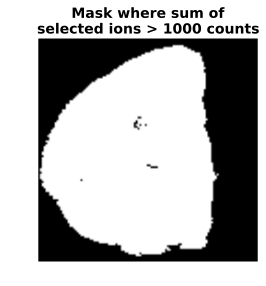

In [8]:
myMask = np.sum(imStack,2)
myMask = myMask > 1000
plt.imshow(myMask,cmap='gray')
plt.axis('off')
plt.title('Mask where sum of\nselected ions > 1000 counts',fontsize=14,color='black',weight='bold')
plt.show()

### Plotting a grid of spectral images
The cell below plots the images for the five chosen ions in three different ways.  Row A shows the raw data.  In Row B, the same ions are normalized by the total intensity of _just the chosen ions_.  Row C is a contrast-enhanced version of Row B in which high intensities are compressed, allowing the colormap to show more variation among low-intensity regions.

Black dots on each image show the pixel locations identified above in `myRows` and `myCols`.  

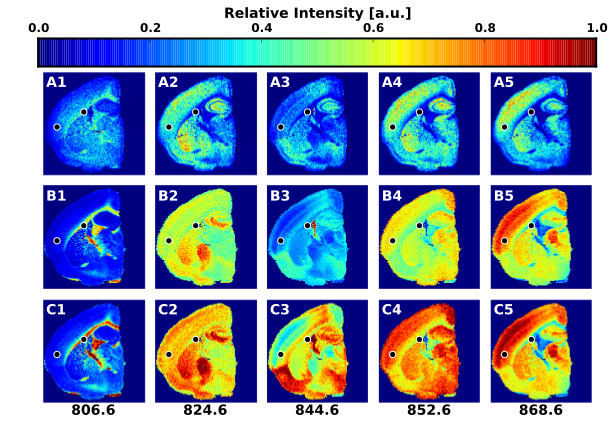

In [9]:

colormap = 'jet'
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (10., 7.))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (3, +len(myIons)), # creates 2x2 grid of axes
                axes_pad=0.02, # pad between axes in inch.
                cbar_location = "top",
                    cbar_mode="single")

# FIRST, PLOT THE SIX IMAGES AS MEASURED
# THE COMMAND "IMSHOW" IS USED WITH TWO ARGUMENTS:
#   1) THE IMAGE: AN [M,N] MATRIX THAT CONTAINS INTENSITY VALUES
#   2) A COLORSCALE
for i in range(len(myIons)):
    img = imStack[:,:,i].astype(float)
    grid[i].imshow(img,cmap=colormap)
    for x,y in zip(myRows,myCols):
#         plt.scatter(x,y, s=500, marker='s', edgecolor='black', linewidth='3', facecolor='green', hatch='|')
        grid[i].scatter(x,y,s=40,marker='o',linewidth='1',edgecolor='w',facecolor='k')
    grid[i].set_axis_off()
    grid[i].text(3,16,'A%d'%(i+1),fontsize=14,color='white',weight='bold')

# SECOND, PLOT THE SAME SIX IMAGES BUT NORMALIZE THE INTENSITY VALUES BY
# THE COMBINED INTENSITY OF THE SIX IONS.
# IN ADDITION, APPLY THE MASK IMAGE WE MADE ABOVE.
for i in range(len(myIons)):
    img = imStack[:,:,i].astype(float)
    img = np.divide(img,np.sum(imStack,2))
    img = np.multiply(img,myMask)
    grid[i+len(myIons)].imshow(img,cmap=colormap)
    for x,y in zip(myRows,myCols):
        grid[i+len(myIons)].scatter(x,y,s=40,marker='o',linewidth='1',edgecolor='w',facecolor='k')
    grid[i+len(myIons)].set_axis_off()
    grid[i+len(myIons)].text(3,16,'B%d'%(i+1),fontsize=14,color='white',weight='bold')

# LASTLY, ENHANCE THE CONTRAST OF EACH IMAGE AFTER NORMALIZATION
# HERE THE INTENSITY IS SCALED FROM THE 1ST TO 98TH PERCENTILE OF VALUES
for i in range(len(myIons)):
    img = imStack[:,:,i].astype(float)
    img = np.divide(img,np.sum(imStack,2))
    img = np.multiply(img,myMask)
    p2, p98 = np.percentile(img, (1, 99))
    img_eq = exposure.rescale_intensity(img, in_range=(p2, p98))
    f = grid[i+len(myIons)*2].imshow(img_eq,cmap=colormap)
    for x,y in zip(myRows,myCols):
        grid[i+len(myIons)*2].scatter(x,y,s=40,marker='o',linewidth='1',edgecolor='w',facecolor='k')
    grid[i+len(myIons)*2].set_axis_off()
    grid[i+len(myIons)*2].text(3,16,'C%d'%(i+1),fontsize=14,color='white',weight='bold')
    grid[i+len(myIons)*2].text(33,136,'%3.1f'%(myIons[i]),fontsize=14,color='black',weight='bold')


# ADD A COLORBAR TO SHOW THE RELATIVE MEANING OF THE RED, BLUE, AND YELLOW COLORS
cbar = grid.cbar_axes[0].colorbar(f)
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(12)
    t.set_fontweight('bold')
cbar.set_label_text("Relative Intensity [a.u.]",fontsize=14,color='black',weight='bold')

# EXPORT THE IMAGE TO A PDF THAT CAN BE EDITED IN VECTOR GRAPHIC SOFTWARE
fig.savefig('Figure_2_image_processing.pdf')


### Plotting mass spectra
The code below plots mass spectra at the pixel locations identified above in `myRows` and `myCols` and which are indicated with black dots in the grid of images.

The m/z ranges plotted in the images above are highlighted with blue-grey bars via the `plt.axvspan()` call.

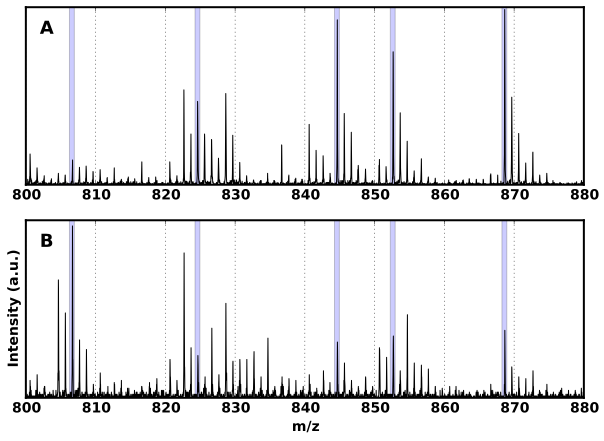

In [10]:
fig = plt.figure(1, (10.,7.))
idx = np.argwhere(np.abs(mz - 840) < 40)
xData = mz[idx]

for i in range(len(intensity)):
    plt.subplot(2,1,i+1)
    yData = np.asarray(intensity[i][:]).astype(float)[idx]
    plt.plot(xData, yData,color='k')
    plt.xlim([800,880])
    plt.yticks([])
    plt.grid(True)
    plt.text(plt.axis()[0]+2,plt.axis()[3]*0.85,chr(i+65),fontsize=18,color='black',weight='bold')
    for ion in myIons:
        plt.axvspan(ion - myRange, ion + myRange, facecolor='b', alpha=0.2)


plt.xlabel('m/z',fontsize=14,color='black',weight='bold')
plt.ylabel('Intensity (a.u.)',fontsize=14,color='black',weight='bold')
  
fig.savefig('Figure_3_spectra_processing.pdf')